<a href="https://colab.research.google.com/github/jackychia/AIforCE/blob/master/LSTM_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
#coding=utf-8
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

# 新增區段

In [48]:
train = pd.read_csv('stock50.csv')
train.head()

,Stock_num,Date,Open,High,Min,Close,Stock_trade
0,50,20170103,67.69,67.88,67.51,67.88,2331
1,50,20170104,67.98,68.07,67.74,67.84,4284
2,50,20170105,67.84,68.45,67.79,68.45,4573
3,50,20170106,68.40,68.69,68.40,68.59,3752
4,50,20170109,68.69,68.87,68.26,68.40,5038


In [49]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return norm
def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
    return np.array(X_train), np.array(Y_train)
def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='linear'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mae", optimizer="adam",metrics=['mae'])
    model.summary()
    return model

In [50]:
train = train.dropna()
train['y'] = train['Close'].shift(-1)
#train = type_result(train)
train.iloc[:,2:4] = normalize(train.iloc[:,2:4])
train.head()

,Stock_num,Date,Open,High,Min,Close,Stock_trade,y
0,50,20170103,0.000000,0.000000,67.51,67.88,2331,67.84
1,50,20170104,0.015978,0.010383,67.74,67.84,4284,68.45
2,50,20170105,0.008264,0.031148,67.79,68.45,4573,68.59
3,50,20170106,0.039118,0.044262,68.40,68.59,3752,68.40
4,50,20170109,0.055096,0.054098,68.26,68.40,5038,68.35


In [51]:
train['Date'] = pd.to_datetime(train['Date'], format='%Y%m%d')
train['weekday'] = train['Date'].apply(lambda x: x.day)
train['year'] = train['Date'].apply(lambda x: x.year)
train['Month'] = train['Date'].apply(lambda x: x.month)
test = train[-30:]
train = train[(train['year']==2017)|((train['year']==2018)&(train['Month']<=3))|((train['year']==2018)&(train['Month']==4)&(train['weekday']<=27))]
#train & test
train = train.reset_index()
test = test.reset_index()
train = train.dropna()

In [52]:
test.head()

,index,Stock_num,Date,Open,High,Min,Close,Stock_trade,y,weekday,year,Month
0,292,50,2018-03-16,0.898623,0.891803,83.10,83.90,5510,83.85,16,2018,3
1,293,50,2018-03-19,0.879339,0.886339,83.45,83.85,2035,83.80,19,2018,3
2,294,50,2018-03-20,0.854545,0.869945,83.20,83.80,2895,83.85,20,2018,3
3,295,50,2018-03-21,0.887603,0.886339,83.60,83.85,4891,83.55,21,2018,3
4,296,50,2018-03-22,0.898623,0.913661,83.45,83.55,3429,82.10,22,2018,3


In [53]:
train.drop(['Stock_num','High','Min','Open','Date','weekday','year','Month',"index"], axis=1, inplace=True)
test.drop(['Stock_num','Date','High','Min','Open','weekday','year','Month','index'], axis=1, inplace=True)
train.head()

,Close,Stock_trade,y
0,67.88,2331,67.84
1,67.84,4284,68.45
2,68.45,4573,68.59
3,68.59,3752,68.40
4,68.40,5038,68.35


In [54]:
X_train, Y_train = train_windows(train, 5, 1)
X_test, Y_test = train_windows(test, 5, 1)

In [55]:
model = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5, 256)            265216    
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 1)              257       
_________________________________________________________________
flatten_4 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 790,821
Trainable params: 790,821
Non-trainable params: 0
________________________________________________

In [56]:
history = model.fit(X_train, Y_train, epochs=1000, batch_size=5, validation_split=0.1, callbacks=[callback],shuffle=True)

Train on 283 samples, validate on 32 samples
Epoch 1/1000
283/283 [==============================] - 4s 13ms/step - loss: 40.6566 - mae: 40.6566 - val_loss: 5.6522 - val_mae: 5.6522
Epoch 2/1000
 25/283 [=>............................] - ETA: 2s - loss: 5.0811 - mae: 5.0811

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `mean_absolute_error` which is not available. Available metrics are: val_loss,val_mae,loss,mae
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


283/283 [==============================] - 2s 8ms/step - loss: 4.2129 - mae: 4.2129 - val_loss: 3.7839 - val_mae: 3.7839
Epoch 3/1000
283/283 [==============================] - 2s 8ms/step - loss: 3.9922 - mae: 3.9922 - val_loss: 3.7168 - val_mae: 3.7168
Epoch 4/1000
283/283 [==============================] - 2s 8ms/step - loss: 3.9813 - mae: 3.9813 - val_loss: 2.4964 - val_mae: 2.4964
Epoch 5/1000
283/283 [==============================] - 2s 8ms/step - loss: 4.1174 - mae: 4.1174 - val_loss: 2.6694 - val_mae: 2.6694
Epoch 6/1000
283/283 [==============================] - 2s 8ms/step - loss: 4.0649 - mae: 4.0649 - val_loss: 2.5774 - val_mae: 2.5774
Epoch 7/1000
283/283 [==============================] - 2s 8ms/step - loss: 4.0765 - mae: 4.0765 - val_loss: 1.9986 - val_mae: 1.9986
Epoch 8/1000
283/283 [==============================] - 2s 8ms/step - loss: 4.0505 - mae: 4.0505 - val_loss: 2.4316 - val_mae: 2.4316
Epoch 9/1000
283/283 [==============================] - 2s 8ms/step - loss:

(0.0, 10.0)

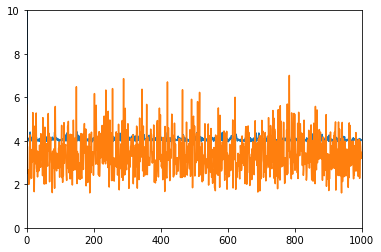

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlim([0,1000])
plt.ylim([0,10])

In [63]:
from keras import backend as K

In [64]:
X_test = K.cast_to_floatx(X_test)
Y_test = K.cast_to_floatx(Y_test)
Y_predict = model.predict(X_test)

In [65]:
Y_predict

array([[78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616],
       [78.79616]], dtype=float32)

In [66]:
Y_test

array([[82.2 ],
       [83.4 ],
       [82.25],
       [82.1 ],
       [82.85],
       [82.95],
       [82.25],
       [81.5 ],
       [82.2 ],
       [82.5 ],
       [82.85],
       [82.5 ],
       [82.5 ],
       [82.3 ],
       [81.4 ],
       [81.6 ],
       [82.65],
       [80.75],
       [79.95],
       [79.55],
       [79.3 ],
       [79.05],
       [79.2 ],
       [80.  ]], dtype=float32)